In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import math

from ipywidgets import interact

from ipywidgets import widgets
from tqdm.auto import tqdm

from dataclasses import dataclass
from typing import Union, Callable, Optional
from copy import deepcopy
from scipy.optimize import root_scalar, brentq
from dataclasses import dataclass
from scipy.special import iv
from scipy.stats import bernoulli
from scipy.interpolate import RectBivariateSpline

import warnings
from  scipy.stats import norm
warnings.filterwarnings("ignore")

# Heston model

Heston model can be written in following way:

$$dS_t/S_t  = rdt + \sqrt{V_t} dW_1$$

$$dV_t = \kappa (\bar V-V_t)dt + \gamma \sqrt V_t dW_2$$

$$dW_1 dW_2 = \rho dt$$

## Euler scheme

It can be simulated in discrete time using Euler scheme by selecting a time step $∆t$ starting at $S_0, V_0$:

$$\log s_{i} = \log s_{i-1} + (r - v_{i-1}^+/2)\Delta t+ \sqrt{v_{i-1}^+ \Delta t}(  ρε^1_{i} + \sqrt{1- ρ^2} ε^2_{i})],$$

$$v_{i} =  v_{i-1} + \kappa (\bar V-v_{i-1}^+)\Delta t + \gamma \sqrt{ v_{i-1}^+ \Delta t}ε^1_{i}$$

(section 2.3 eq. 6-7 Andersen (2006) )

In [5]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

@dataclass
class HestonParameters:
    kappa:  Union[float, np.ndarray]
    gamma:  Union[float, np.ndarray]
    rho:  Union[float, np.ndarray]
    vbar:  Union[float, np.ndarray]
    v0:  Union[float, np.ndarray]
        
@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    interest_rate: Union[float, np.ndarray]

In [6]:



"""Твоя оберта здесь"""







In [7]:
def simulate_heston_euler(state: MarketState,
                                heston_params: HestonParameters,
                                time: float = 1.,
                                dt: float = 1e-2,
                                time_batch_size: int = 10_000,
                                n_simulations: int = 10_000) -> dict:
    
    if time<=0:
        raise Error("time must be bigger then 0")
    
    # initialize market and model parameters
    r, s0 = state.interest_rate, state.stock_price
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    
    vt = np.zeros(n_simulations)
    vt[:] = v0
    log_st = np.zeros(n_simulations)
    log_st[:] = np.log(s0)
    
    N_T = int(time / dt)
    num_of_time_batch = int(N_T/time_batch_size)
    
    for k in tqdm(range(num_of_time_batch)):
        Z1 = np.random.normal(size=(n_simulations, time_batch_size))
        Z2 = np.random.normal(size=(n_simulations, time_batch_size))
        V = np.zeros([n_simulations, time_batch_size])
        V[:, 0] = vt

        logS = np.zeros([batch_size, time_batch_size])
        logS[:, 0] = log_st

        for i in range(0, time_batch_size-1):
            vmax=np.maximum(V[:, i],0)
            S1 = (r - 0.5 * vmax) * (dt)
            S2 = np.sqrt(vmax*(dt)) * Z1[:, i]
            logS[:, i+1] = logS[:, i] + S1 + S2
            V1 = kappa*(vbar - vmax)*(dt)
            V2 = gamma*np.sqrt(vmax*(dt))*(rho*Z1[:, i]+np.sqrt(1-rho**2)*Z2[:, i])
            V[:, i+1] = V[:, i] + V1 + V2
        vt = V[:, time_batch_size-1]
        log_st = logS[:, time_batch_size-1]

    if N_T > num_of_time_batch*time_batch_size:
        add_batch_time = N_T - num_of_time_batch*time_batch_size

        Z1 = np.random.normal(size=(n_simulations, add_batch_time))
        Z2 = np.random.normal(size=(n_simulations, add_batch_time))
        V = np.zeros([n_simulations, add_batch_time])
        V[:, 0] = vt

        logS = np.zeros([n_simulations, add_batch_time])
        logS[:, 0] = log_st

        for i in range(0, add_batch_time-1):
            vmax=np.maximum(V[:, i],0)
            S1 = (r - 0.5 * vmax) * (dt)
            S2 = np.sqrt(vmax*(dt)) * Z1[:, i]
            logS[:, i+1] = logS[:, i] + S1 + S2
            V1 = kappa*(vbar - vmax)*(dt)
            V2 = gamma*np.sqrt(vmax*(dt))*(rho*Z1[:, i]+np.sqrt(1-rho**2)*Z2[:, i])
            V[:, i+1] = V[:, i] + V1 + V2
        vt = V[:, add_batch_time-1]
        log_st = logS[:, add_batch_time-1]        
    
    #put the calculated values into the dictionary
    
    return {"price": np.exp(log_st), "volatility": vt}

## Broadie - Kaya scheme

In [8]:
def cir_chi_sq_sample(heston_params: HestonParameters,
                      dt: float,
                      v_i: np.array,
                      n_simulations: int):
    """Samples chi_sqqred statistics for v_{i+1} conditional on 
       v_i and parameters of Hestom model. 
        
    Args:
        heston_params (HestonParameters): parameters of Heston model
        dt (float): time step 
        v_i: current volatility value
        n_simulations (int): number of simulations.
        
    Returns:
        np.array: sampled chi_squared statistics 
    """
    kappa, vbar, gamma = heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    barkappa=v_i*(4*kappa*np.exp(-kappa*dt))/(gamma**2 * (1 - np.exp(-kappa*dt)))
    d=(4*kappa*vbar)/(gamma**2)
    c=((gamma**2)/(4*kappa))*(1-np.exp(-kappa*dt))
    
    return  c*np.random.noncentral_chisquare(size = n_simulations, df   = d, nonc = barkappa)


def Phi(a: Union[float, np.ndarray], 
         V: Union[float, np.ndarray],
         time: Union[float, np.ndarray],
         heston_params: HestonParameters) -> np.ndarray:
    
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                        heston_params.vbar, heston_params.gamma
    dt = time[1::]-time[:-1:]
    
    A=np.array(a)
    gamma_a = np.sqrt(kappa**2 - 2*gamma**2*1j*A).reshape(1,1,len(A)).T
    
    E1 = np.exp(-kappa*dt)
    E2 = np.exp(-gamma_a * dt)
        
    P1 = ((1.0-E1)*gamma_a/(kappa*(1.0-E2)))*np.exp(-0.5*(gamma_a - kappa)*dt)
    
    P2_2 = kappa * (1.0 + E1)/(1.0 - E1) - gamma_a*(1.0+E2)/(1-E2)
    P2 = np.exp( (V[:,1::]+V[:,:-1:])/(gamma_a**2) * P2_2 )
    
    P3_1 = np.sqrt(V[:,1::]*V[:,:-1:])*4*gamma_a * np.exp(-0.5*gamma_a*dt) /(gamma**2 * (1.0 - E2))
    P3_2 = np.sqrt(V[:,1::]*V[:,:-1:])*4*kappa*np.exp(-0.5*kappa*dt)/(gamma**2 * (1 - E1))
    d=(4*kappa*vbar)/(gamma**2)
    P3 = iv(0.5*d - 1, P3_1)/iv(0.5*d - 1, P3_2)
    
    return P1*P2*P3

def Pr(V: np.ndarray, time: np.ndarray,
       X: Union[np.ndarray, float],
       heston_params: HestonParameters,
       h: float=1e-2, eps: float=1e-2) -> np.ndarray:
    
    x=np.array(X)
    P=h*x/np.pi
    S = 0.0
    j = 1
    while(True):
        Sin=np.sin(h*j*x)/j
        Phi_hj=Phi(h*j, V, time, heston_params)
        S+=Sin.reshape(1,1,len(x)).T * Phi_hj[0]
        if np.all(Phi_hj[0]<np.pi*eps*j/2.0):
            break
        j=j+1
    
    S=S*2.0/np.pi
    return P+S

def IV(V: np.ndarray, time: np.ndarray,
       heston_params: HestonParameters,
       h: float=1e-2, eps: float=1e-2) -> np.ndarray:
    
    U=np.random.uniform(size=(V.shape[0], V.shape[1] - 1))
    
    def f(x,i,j):
        P=Pr(V, time, x, heston_params, h, eps)
        return (P-U)[0][i,j]
    
    IVar = np.zeros((V.shape[0], V.shape[1] - 1))
    
    for i in range(IVar.shape[0]):
        for j in range(IVar.shape[1]):     
            IVar[i,j]=root_scalar(f, args=(i,j), x0=0.5, method='newton')
    return IVar

# Andersen scheme

In [9]:
def simulate_heston_andersen(state: MarketState,
                                    heston_params: HestonParameters,
                                    time: float = 1.,
                                    dt: float = 1e-2,
                                    n_simulations: int = 10_000,
                                    time_batch_size: int = 10_000,
                                    Psi_c: float=1.5,
                                    gamma_1: float=0.5) -> dict:
    
    
    if Psi_c>2 or Psi_c<1:
        raise Error('1<=Psi_c<=2 ')
    if gamma_1 >1 or gamma_1<0:
        raise Error('0<=gamma_1<=1')
        
    gamma_2 = 1.0 - gamma_1
    
    r, s0 = state.interest_rate, state.stock_price
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    
    E = np.exp(-kappa*dt)
    
    K_0 = -(rho*kappa*vbar/gamma)*dt
    K_1 = gamma_1*dt*(rho*kappa/gamma - 0.5) - rho/gamma
    K_2 = gamma_2*dt*(rho*kappa/gamma - 0.5) + rho/gamma
    K_3 = gamma_1*dt*(1.0 - rho**2)
    K_4 = gamma_2*dt*(1.0 - rho**2)
    
    N_T = int(time / dt)
    num_of_time_batch = int(N_T/time_batch_size)
    
    
    vt = np.zeros(n_simulations)
    vt[:] = v0
    log_st = np.zeros(n_simulations)
    log_st[:] = np.log(s0)
    
    mean_St = 0.
    mean_vt = 0.
    
        
    vt[:] = v0
    log_st[:] = np.log(s0)
        
    for k in range(num_of_time_batch):

        V = np.zeros([n_simulations, time_batch_size])
        V[:, 0] = vt

        logS = np.zeros([n_simulations, time_batch_size])
        logS[:, 0] = log_st

        Z = np.random.normal(size=(n_simulations, time_batch_size))


        for i in range(time_batch_size - 1):
            m=vbar+(V[:, i] - vbar)*E
            s_2 = (V[:, i]*(gamma**2)*E/kappa)*(1.0 - E) + (vbar*gamma**2)/(2.0*kappa)*((1-E)**2)

            Psi = s_2/(m**2)

            cond = np.where(Psi<=Psi_c)
            c = 2/Psi[cond]
            b = c - 1 + np.sqrt(c*(c - 1))
            a = m[cond]/(1+b)
            b=np.sqrt(b)
            Z_V = np.random.normal(size=cond[0].shape[0])
            V[cond, i+1] = a*((b+Z_V)**2)

            cond = np.where(Psi>Psi_c)
            p = (Psi[cond] - 1)/(Psi[cond] + 1)
            beta = (1.0 - p)/m[cond]

            ksi = np.random.binomial(1, 1.0-p, size=cond[0].shape[0])
            eta = np.random.exponential(scale = 1/beta, size=cond[0].shape[0])
            V[cond,i+1]=ksi*eta


            logS[:,i+1] = logS[:,i] + r*dt+K_0 + K_1*V[:,i] + K_2*V[:,i+1] \
                            + np.sqrt(K_3*V[:,i]+K_4*V[:,i+1]) * Z[:,i]

        vt = V[:, time_batch_size-1]
        log_st = logS[:, time_batch_size-1]

    if N_T > num_of_time_batch*time_batch_size:

        add_batch_time = N_T - num_of_time_batch*time_batch_size

        V = np.zeros([n_simulations, add_batch_time])
        V[:, 0] = vt
        logS = np.zeros([n_simulations, add_batch_time])
        logS[:, 0] = log_st
        
        Z = np.random.normal(size=(n_simulations, add_batch_time))

        for i in range(add_batch_time - 1):
            m=vbar+(V[:, i] - vbar)*E
            s_2 = (V[:, i]*(gamma**2)*E/kappa)*(1.0 - E) + (vbar*gamma**2)/(2.0*kappa)*((1-E)**2)

            Psi = s_2/(m**2)

            cond = np.where(Psi<=Psi_c)
            c = 2/Psi[cond]
            b = c - 1 + np.sqrt(c*(c - 1))
            a = m[cond]/(1+b)
            b=np.sqrt(b)
            Z_V = np.random.normal(size=cond[0].shape[0])
            V[cond, i+1] = a*((b+Z_V)**2)

            cond = np.where(Psi>Psi_c)
            p = (Psi[cond] - 1)/(Psi[cond] + 1)
            beta = (1.0 - p)/m[cond]

            ksi = np.random.binomial(1, 1.0-p, size=cond[0].shape[0])
            eta = np.random.exponential(scale = 1/beta, size=cond[0].shape[0])
            V[cond,i+1]=ksi*eta


            logS[:,i+1] = logS[:,i] + r*dt+K_0 + K_1*V[:,i] + K_2*V[:,i+1] \
                            + np.sqrt(K_3*V[:,i]+K_4*V[:,i+1]) * Z[:,i]

        vt = V[:, add_batch_time-1]
        log_st = logS[:, add_batch_time-1]
            
            
        
    #put the calculated values into the dictionary
    simulated_paths = {"price": np.exp(log_st), "volatility": vt}
    return simulated_paths

In [13]:
from typing import Union
from numpy import float_
from numpy.typing import NDArray
from numba.types import CPointer, float64, complex128, intc  # type: ignore
from dataclasses import dataclass
import math
import cmath
import numpy as np
import numba                     # type: ignore
import scipy.stats as st         # type: ignore
import scipy.optimize as opt     # type: ignore
import scipy.integrate as intg   # type: ignore
import scipy.special as spec     # type: ignore
import scipy.misc as spmisc      # type: ignore
from scipy import LowLevelCallable
# from . import blackscholes


# The following two functions are used to implement Heston's formula with Numba

@numba.njit(complex128(
    float64, float64, float64, float64, float64, float64, complex128, float64))
def _heston_cf(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho*sigma*u*1j - kappa)**2 + sigma**2*(u*1j + u**2))
    g = ((rho*sigma*u*1j - kappa + d) / (rho*sigma*u*1j - kappa - d))
    C = (kappa*theta/sigma**2 * (
        t*(kappa - rho*sigma*u*1j - d) -
        2*cmath.log((1 - g*cmath.exp(-d*t))/(1-g))))
    D = ((kappa - rho*sigma*u*1j - d)/sigma**2 *
         ((1 - cmath.exp(-d*t)) / (1 - g*cmath.exp(-d*t))))
    return cmath.exp(C + D*v + u*math.log(s)*1j)


@numba.cfunc(float64(intc, CPointer(float64)))
def _heston_integrand(n, x):
    """Integrand in Heston's formula."""
    # x = (u, t, k, s, v, kappa, theta, sigma, rho)
    u = x[0]
    t = x[1]
    k = x[2]
    s = x[3]
    v = x[4]
    kappa = x[5]
    theta = x[6]
    sigma = x[7]
    rho = x[8]
    return (cmath.exp(-1j*u*math.log(k))/(1j*u) *
            (_heston_cf(s, v, kappa, theta, sigma, rho, u-1j, t) -
             k*_heston_cf(s, v, kappa, theta, sigma, rho, u, t))).real


@dataclass
class Heston:
    """The Heston model.
    The base asset is stock which under the pricing measure follows the SDEs
        ```
        d(S_t) = r*S_t*dt + sqrt(V_t)*d(W^1_t),
        d(V_t) = kappa*(theta - V_t)*dt + sigma*sqrt(V_t)*d(W^2_t)
        ```
    where `r` is the interest rate, `V_t` is the variance process, `W^1_t` and
    `W^2_t` are standard Brownian motions with correlation coefficient `rho`,
    and `kappa>0, theta>0, sigma>0, -1 < rho < 1` are the model parameters.
    Attributes:
        s: Initial price, i.e. S_0.
        v: Initial variance, i.e. v_0.
        kappa, theta, sigma, rho: Model parameters.
        r: Interest rate.
    Methods:
        call_price: Computes call option price.
        iv: Computes implied volatility produced by the model.
        calibrate: Calibrates parameters of the model.
        simulate_euler: Simulates paths by Euler's scheme.
        simulate_qe: Simulates paths by Andersen's QE scheme.
        simulate_exact: Simulates paths by Broadie-Kaya's exact scheme.
    """
    s: float
    v: float
    kappa: float
    theta: float
    sigma: float
    rho: float
    r: float = 0

    def _call_price_scalar(self, t: float, k: float) -> float:
        """Computes the price of a call option by Heston's semi-closed formula.
        This is an auxiliary function which works with scalar expiration time
        and strike. It is called by `call_price`, which allows vectorization.
        """
        return (0.5*(self.s - math.exp(-self.r*t)*k) +
                1/math.pi * math.exp(-self.r*t) *
                intg.quad(
                    LowLevelCallable(_heston_integrand.ctypes),
                    0, math.inf,
                    args=(t, k, self.s, self.v, self.kappa, self.theta,
                          self.sigma, self.rho))[0])

    def call_price(
        self,
        t: Union[float, NDArray[float_]],
        k: Union[float, NDArray[float_]]
    ) -> Union[float, NDArray[float_]]:
        """Computes the price of a call option by Heston's semi-closed formula.
        Args:
            t: Expiration time (float or ndarray).
            k: Strike (float or ndarray).
        Returns:
            If `t` and `k` are scalars, returns the price of a call option as a
            scalar value. If `t` and/or `k` are arrays, applies NumPy
            broadcasting rules and returns an array of prices.
        Notes:
            Here we use the stable representation of the characteristic
            function, see Albrecher et al. "The little Heston trap" (2007).
        """
        b = np.broadcast(t, k)
        if b.nd:  # Vector arguments were supplied
            return np.fromiter(
                (self._call_price_scalar(t_, k_) for (t_, k_) in b),
                count=b.size, dtype=float_).reshape(b.shape)
        else:
            return self._call_price_scalar(t, k)

In [16]:
model = Heston(state.stock_price, heston_parameters.v0, heston_parameters.kappa, 
                         heston_parameters.vbar, heston_parameters.gamma, heston_parameters.rho, state.interest_rate)

In [17]:
model.call_price(2., 100.)

19.27381160707458

In [ ]:
time = 2.
heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, 
                                     rho = -0.3937, vbar = 0.0641, 
                                     v0 = 0.3)

state = MarketState(stock_price = 100., interest_rate = 0.)

n_simulations = 120000

eul = simulate_heston_euler(state = state, heston_params = heston_parameters,
                            time = time, n_simulations = 40_000)

ander = simulate_heston_andersen(state= state, heston_params = heston_parameters, time = 2., n_simulations = 40_000)

In [128]:
def d_1(q,T,S,K,r):
    denom=1/(q*np.sqrt(T))
    log=np.log(S/K)
    s2=T*(r+q*q/2)
    return denom*(log+s2)

def d_2(q,T,S,K,r):
    denom=1/(q*np.sqrt(T))
    log=np.log(S/K)
    s2=T*(r-q*q/2)
    
    return denom*(log+s2)

def calc_iv(option: CallStockOption, state: MarketState, option_price: float):
    
    T=option.expiration_time
    K=option.strike_price
    S=state.stock_price
    r=state.interest_rate    
    N=sps.norm()
    
    
    def f(q):
        d1=d_1(q,T,S,K,r)
        d2=d_2(q,T,S,K,r)
        return S*N.cdf(d1)-K*(np.exp(-r*T))*N.cdf(d2)-option_price
    
    def fprime(q):
        d1=d_1(q,T,S,K,r)
        return S*sps.norm().pdf(d1)*np.sqrt(T)
    
    sol = root_scalar(f, x0=0.5, fprime=fprime, method='newton')
    return sol.root



In [129]:
IV = np.empty_like(call_price_andersen)

for i in range(len(calls.expiration_time)):
    for j in range(len(calls.strike_price)):
        IV[i, j] = calc_iv(option=CallStockOption(calls.strike_price[0][j], calls.expiration_time[i][0]), 
                           state=state, 
                           option_price=call_price_andersen[i, j])

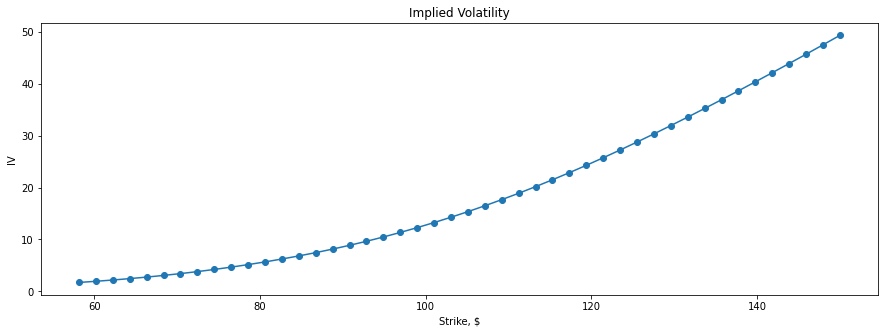

In [138]:
_, ax = plt.subplots(figsize=(15, 5))

ax.plot(strikes[4::], IV[99][4::], "o-")
# ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV")
ax.set_title("Implied Volatility")
plt.show()